In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from graph_funcs import *
from data_funcs import *

# -------------------- Make empyty dataframes w/ right cols to fill with data

rn_samp = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/170313_2018.pkl')
ambe_samp = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/170316_0834.pkl')

rn = pd.DataFrame(columns = list(rn_samp))
ambe = pd.DataFrame(columns = list(ambe_samp))

# ------------------- Import it ALL into one dataframe

for filename in os.listdir('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/' + str(filename))
    rn = rn.append(df)

for filename in os.listdir('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/' + str(filename))
    ambe = ambe.append(df)
    
ambe = ambe[ambe.s2>200]

In [3]:
# ------------------- The linear cut used in s2 - other largest s2 space for SS

def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

In [4]:
# Load in sim data
import hax

# using modified version of Tianyu's OtherLargeS2s peak extractor
from make_minitree import Peaks

hax.init(experiment='XENON1T',
         use_runs_db=False,
         pax_version_policy='loose',
         main_data_paths=['/home/shawaf/data/mc_ambe_samp_2/'],
         minitree_paths = ['/home/shawaf/data/mc_ambe_samp_2/'])

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


In [5]:
from data_funcs import *
sim = hax.minitrees.load("mc_ambe_samp_2",[Peaks])
sim = sim[sim.s2>200]

sim = chosen_cuts(sim)

DEBUG:hax.minitrees] Minitree mc_ambe_samp_2_Peaks.root not found
DEBUG:hax.minitrees] Not found in non-preferred formats either. Minitree will be created.


Could not find run number for mc_ambe_samp_2, got exception <class 'AttributeError'>: 'NoneType' object has no attribute 'query'. Setting run number to 0.
Don't know a run named mc_ambe_samp_2, trying to find it anyway...


INFO:ROOT.TUnixSystem.ACLiC] creating shared library /home/shawaf/xenon1t/sim_comparisons/pax_event_class-5b1cfe34587b2a455c50b0087affb274_cpp.so
INFO:rootpy.stl] generating dictionary for std::vector<Hit> ...
INFO:ROOT.TUnixSystem.ACLiC] creating shared library /home/shawaf/.cache/rootpy/x86_64-60403/dicts/c500f23cb50730e6.so
INFO:rootpy.stl] generating dictionary for std::vector<Interaction> ...
INFO:ROOT.TUnixSystem.ACLiC] creating shared library /home/shawaf/.cache/rootpy/x86_64-60403/dicts/f0de773f36bea4d7.so
INFO:rootpy.stl] generating dictionary for std::vector<ConfidenceTuple> ...
INFO:ROOT.TUnixSystem.ACLiC] creating shared library /home/shawaf/.cache/rootpy/x86_64-60403/dicts/c95f285d363d32d6.so
INFO:rootpy.stl] generating dictionary for std::vector<ReconstructedPosition> ...
INFO:ROOT.TUnixSystem.ACLiC] creating shared library /home/shawaf/.cache/rootpy/x86_64-60403/dicts/4b2ebdec9a11ef94.so
INFO:rootpy.stl] generating dictionary for std::vector<Peak> ...
INFO:ROOT.TUnixSyst

Don't know a run named mc_ambe_samp_2, trying to find it anyway...


DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/mc_ambe_samp_2/mc_ambe_samp_2_Peaks.root
DEBUG:hax.minitrees] Removing weird index column


In [6]:
# need some more quantities of the data
sim['r'] = np.sqrt(sim.x**2 + sim.y**2)
ambe['r'] = np.sqrt(ambe.x**2 + ambe.y**2)

sim['s2_1_r'] = np.sqrt(sim.s2_1_x**2 + sim.s2_1_y**2)
ambe['s2_1_r'] = np.sqrt(ambe.s2_1_x**2 + ambe.s2_1_y**2)

Have all the data ready, now to go through the spaces and compare simulation to real data

# Area, width ---- s2 and largest other  s2

## Main s2

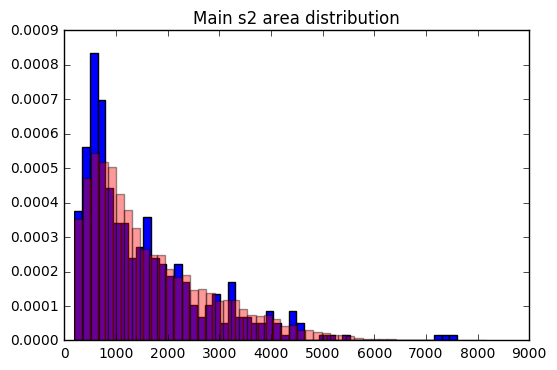

In [7]:
plt.hist(sim.s2.dropna(),bins=50, color='b',label='sim', normed=1)
plt.hist(ambe.s2, bins=50,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Main s2 area distribution')
plt.show()

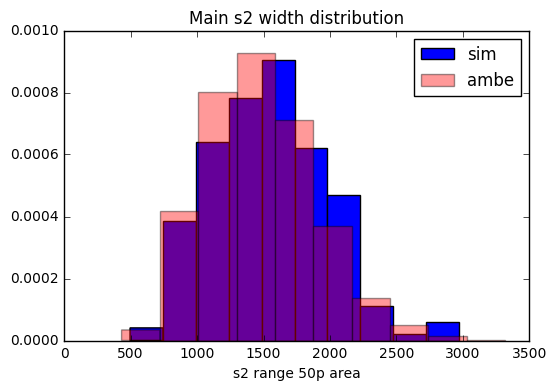

In [43]:
plt.hist(sim.s2_range_50p_area.dropna(),bins=10, color='b',label='sim', normed=1)
plt.hist(ambe.s2_range_50p_area.dropna(), bins=10,alpha=.4,color='r',label='ambe', normed=1)
plt.legend(loc='upper right')
plt.title('Main s2 width distribution')
plt.xlabel('s2 range 50p area')
plt.show()

In [9]:
df1 = ambe.s2_range_50p_area
df2 = sim.s2_range_50p_area
print('ambe \n')
describe_dist(df1)
print('\n sim')
describe_dist(df2)

ambe 

         Q1        Q3      mean    median       std
0 1.168e+03 1.737e+03 1.474e+03 1.442e+03 4.135e+02

 sim
         Q1        Q3      mean    median       std
0 1.225e+03 1.836e+03 1.547e+03 1.525e+03 4.288e+02


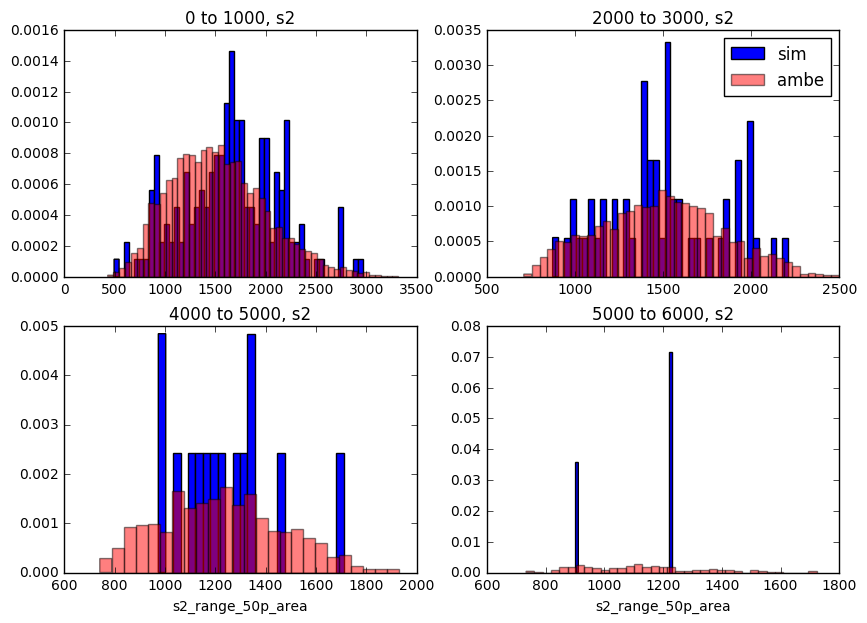

In [10]:
plt_ranges = [[0,1000],[2000,3000],[4000,5000],[5000,6000]]
four_hist_compare(sim, ambe, 's2', 's2_range_50p_area', plt_ranges)

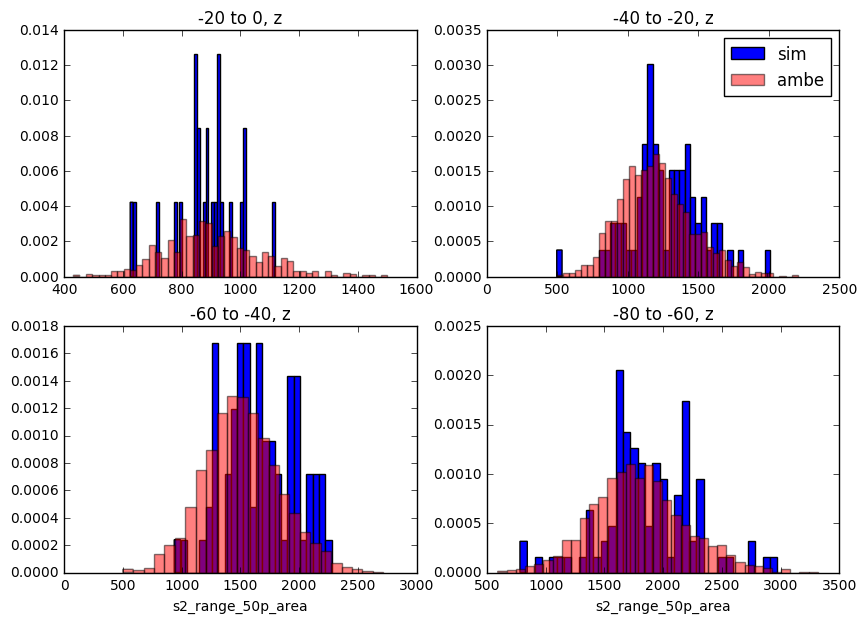

In [11]:
plt_ranges = [[-20,0],[-40, -20],[-60,-40],[-80,-60]]
four_hist_compare(sim[sim.s2<2000], ambe[ambe.s2<2000], 'z', 's2_range_50p_area', plt_ranges)

In [12]:
def s2_width_model(z):
    diffusion_constant = 2.280000e-08
    v_drift = 1.440000e-04
    w0 = 309.7
    return np.sqrt(w0 ** 2 - 5.880 * diffusion_constant * z / v_drift ** 3)


def slicing_for_diff(df, x_feat, y_feat, bins):
    """Designed to slice in a 2-d space, fit gauss to those slices, and return a binned dataframe"""
    bin_mids = []
    
    sigmas = []
    means = []
    diffs = []

    for i in range(1, len(bins)):
        a = df.loc[(df[x_feat] < bins[i]) & (df[x_feat] > bins[i-1])]

        mn = np.mean(a[y_feat])
        sg = np.std(a[y_feat])
        bm = np.mean(a[x_feat])
        mz = np.mean(a['z'])
        diff = s2_width_model(mz)

        if (np.logical_not(np.isnan(mn)) & np.logical_not(np.isnan(sg))):
            means.append(mn)
            sigmas.append(sg)
            bin_mids.append(bm)
            diffs.append(diff)

    return pd.DataFrame(np.array([bin_mids, means, sigmas, diffs]).T, index = range(len(means)), columns = [x_feat,y_feat,'sigma','diffs'])


In [13]:
ambe_bins = np.linspace(0,8000,30)
sim_bins = np.linspace(0,8000,28)
ambe_area_width = slicing_for_diff(ambe, 's2', 's2_range_50p_area', ambe_bins)
sim_area_width = slicing_for_diff(sim, 's2', 's2_range_50p_area', sim_bins)

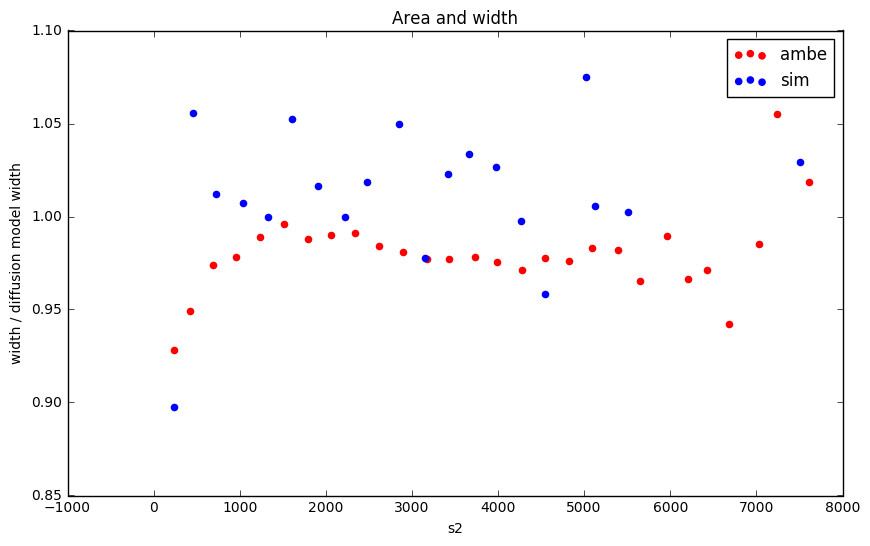

In [14]:
plt.figure(figsize = (10,6))
plt.scatter(ambe_area_width.s2, ambe_area_width.s2_range_50p_area/ambe_area_width.diffs,  color = 'r', marker='o', label='ambe')
plt.scatter(sim_area_width.s2, sim_area_width.s2_range_50p_area/sim_area_width.diffs,  color = 'b',marker='o', label = 'sim')
plt.title('Area and width')
plt.xlabel('s2')
plt.ylabel('width / diffusion model width')
plt.legend(loc='upper right')
plt.show()

## Largest other s2

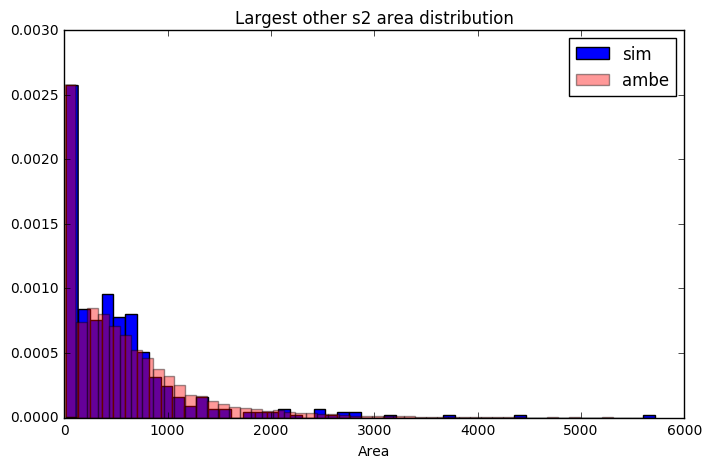

In [15]:
plt.figure(figsize=(8,5))
plt.hist(sim.s2_1_area.dropna(),bins=50, color='b',label='sim', normed=1)
plt.hist(ambe.s2_1_area.dropna(), bins=50,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Largest other s2 area distribution')
plt.xlabel('Area')
plt.legend()
plt.show()

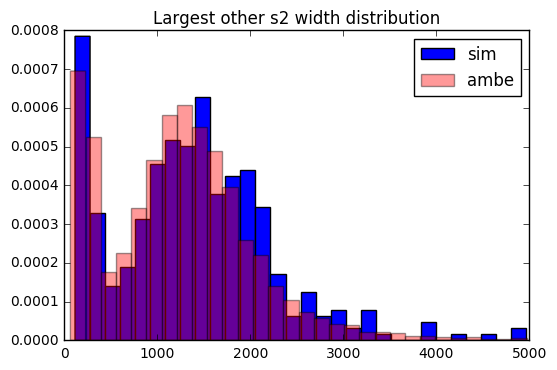

In [16]:
plt.hist(sim[sim.s2_1_range_50p_area < 5000].s2_1_range_50p_area.dropna(),bins=30, color='b',label='sim', normed=1)
plt.hist(ambe[ambe.s2_1_range_50p_area < 5000].s2_1_range_50p_area.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Largest other s2 width distribution')
plt.legend()
plt.show()

In [17]:
df1 = ambe.s2_1_range_50p_area
df2 = sim.s2_1_range_50p_area
print('ambe \n')
describe_dist(df1)
print('\n sim')
describe_dist(df2)

ambe 

         Q1        Q3      mean    median       std
0 6.624e+02 1.682e+03 1.259e+03 1.225e+03 8.509e+02

 sim
         Q1        Q3      mean    median       std
0 8.283e+02 1.896e+03 1.403e+03 1.369e+03 8.839e+02


# r, z, time delays

## Main s2

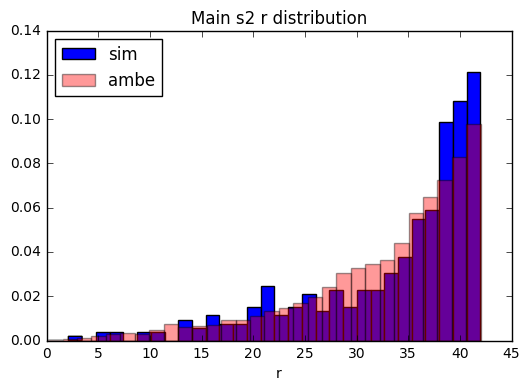

In [18]:
plt.hist(sim.r.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.r.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Main s2 r distribution')
plt.legend(loc = 'upper left')
plt.xlabel('r')
plt.show()

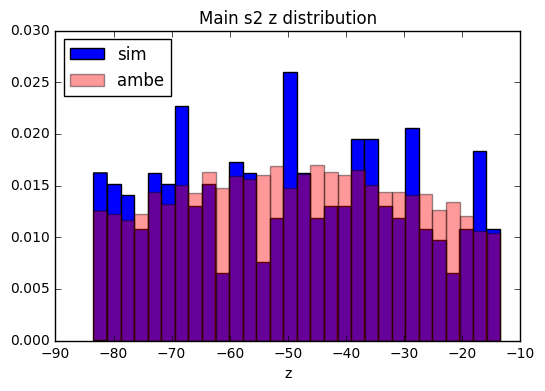

In [19]:
plt.hist(sim.z.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.z.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Main s2 z distribution')
plt.legend(loc = 'upper left')
plt.xlabel('z')
plt.show()

## Largest other s2

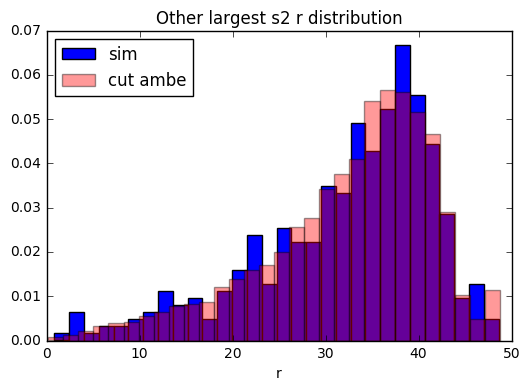

In [20]:
plt.hist(sim.s2_1_r.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.s2_1_r.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Other largest s2 r distribution')
plt.legend(loc = 'upper left')
plt.xlabel('r')
plt.show()

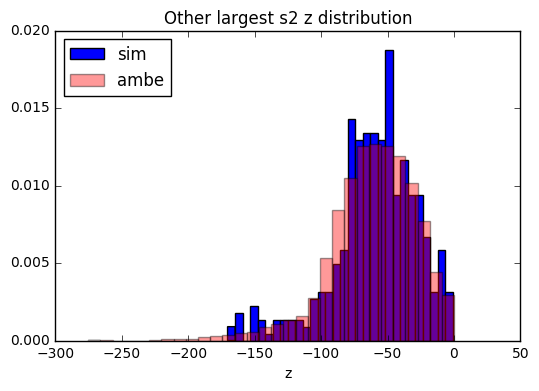

In [21]:
plt.hist(sim.s2_1_z.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe.s2_1_z.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Other largest s2 z distribution')
plt.legend(loc = 'upper left')
plt.xlabel('z')
plt.show()

# Distance between s2, largest other s2

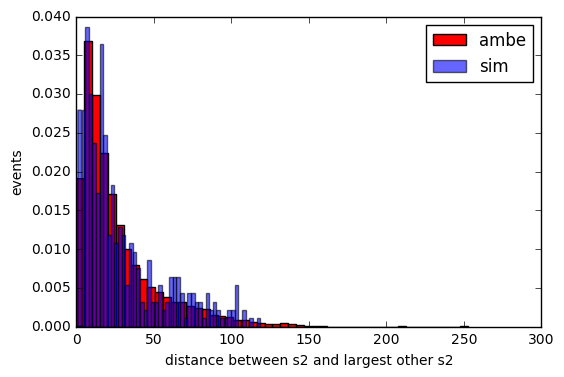

In [22]:
ambe['dist'] = np.sqrt((ambe.s2_1_x - ambe.x)**2 + 
                           (ambe.s2_1_y - ambe.y)**2 + 
                           (ambe.s2_1_z - ambe.z)**2 )

sim['dist'] = np.sqrt((sim.s2_1_x - sim.x)**2 + 
                           (sim.s2_1_y - sim.y)**2 + 
                           (sim.s2_1_z - sim.z)**2 )


plt.hist(ambe.dist.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.dist.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('distance between s2 and largest other s2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

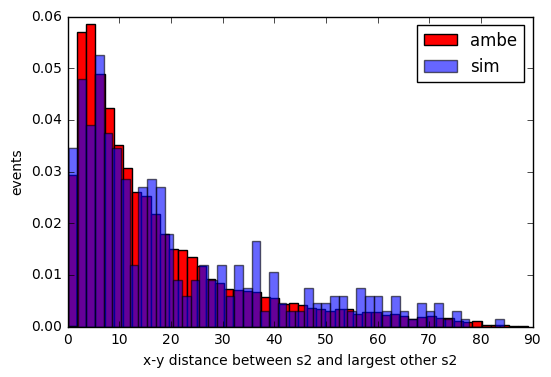

In [23]:
ambe['dist'] = np.sqrt((ambe.s2_1_x - ambe.x)**2 + 
                           (ambe.s2_1_y - ambe.y)**2 )

sim['dist'] = np.sqrt((sim.s2_1_x - sim.x)**2 + 
                           (sim.s2_1_y - sim.y)**2 )


plt.hist(ambe.dist.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.dist.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('x-y distance between s2 and largest other s2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

## Time delays

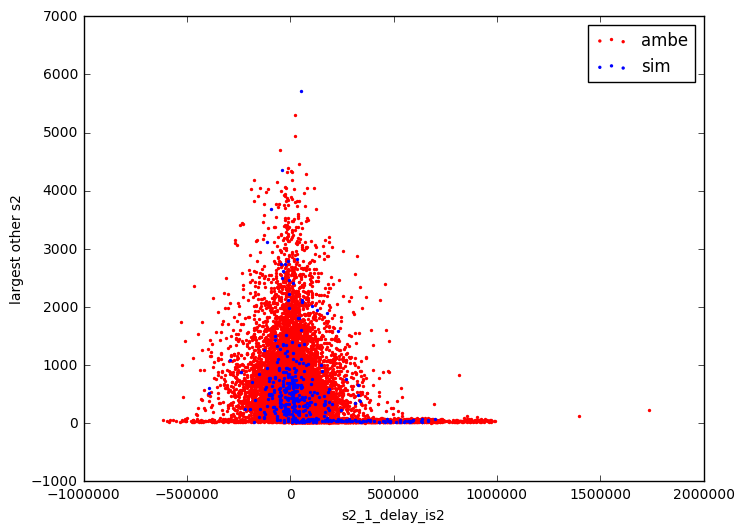

In [24]:
plt.figure(figsize = (8,6))
plt.scatter(ambe.s2_1_delay_is2, ambe.s2_1_area,label='ambe', color='r',s = 2)
plt.scatter(sim.s2_1_delay_is2, sim.s2_1_area, label='sim', color = 'b', s = 2)


plt.title('')
plt.xlabel('s2_1_delay_is2')
plt.ylabel('largest other s2')

plt.legend(loc = 'upper right')
plt.show()

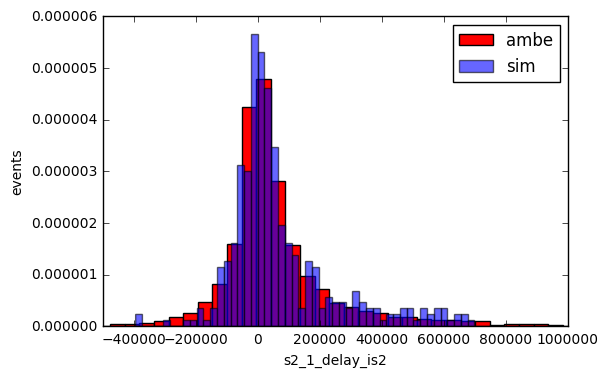

In [25]:
plt.hist(ambe.s2_1_delay_is2.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.s2_1_delay_is2.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('s2_1_delay_is2')
plt.ylabel('events')

plt.xlim(-500000, 1000000)

plt.legend(loc='upper right')

plt.show()

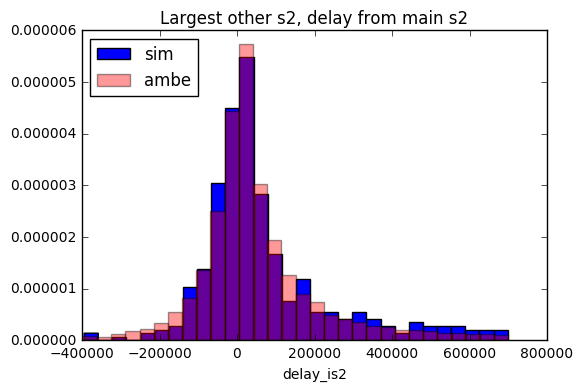

In [26]:
plt.hist(sim[(sim.s2_1_delay_is2 > -400000) & (sim.s2_1_delay_is2 < 700000)].s2_1_delay_is2.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(ambe[(ambe.s2_1_delay_is2 > -400000) & (ambe.s2_1_delay_is2 < 700000)].s2_1_delay_is2.dropna(), bins=30,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Largest other s2, delay from main s2')
plt.legend(loc = 'upper left')
plt.xlabel('delay_is2')
plt.show()

In [27]:
df1 = ambe[(ambe.s2_1_delay_is2 > -400000) & (ambe.s2_1_delay_is2 < 700000)].s2_1_delay_is2
df2 = sim[(sim.s2_1_delay_is2 > -400000) & (sim.s2_1_delay_is2 < 700000)].s2_1_delay_is2
print('ambe \n')
describe_dist(df1)
print('\n sim')
describe_dist(df2)

ambe 

          Q1        Q3      mean    median       std
0 -2.678e+04 9.499e+04 5.104e+04 1.975e+04 1.569e+05

 sim
          Q1        Q3      mean    median       std
0 -2.479e+04 1.097e+05 7.160e+04 2.283e+04 1.745e+05


In [28]:
bins = np.linspace(0,700000,10)
ambe_delay_area = slicing(ambe, 's2_1_delay_is2', 's2_1_area', bins)
sim_delay_area = slicing(sim, 's2_1_delay_is2', 's2_1_area', bins)

### Looking between 0 and 700,000 delay from main s2

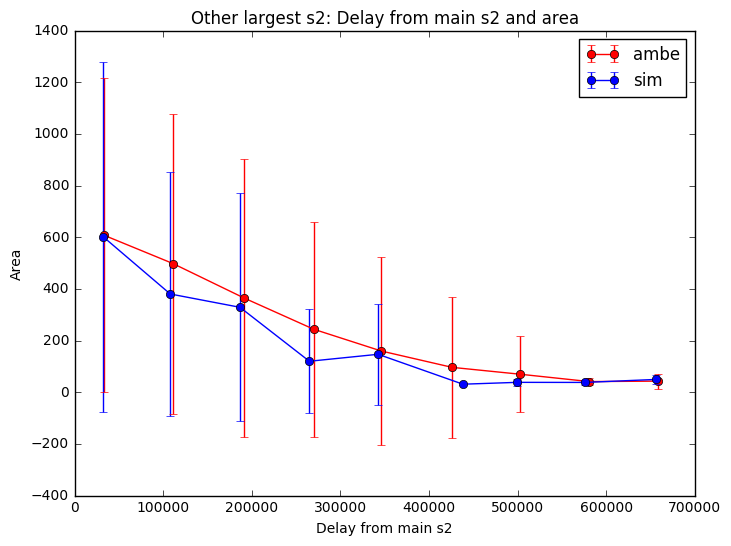

In [29]:
plt.figure(figsize=(8,6))
plt.errorbar(ambe_delay_area.s2_1_delay_is2, ambe_delay_area.s2_1_area, ambe_delay_area.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(sim_delay_area.s2_1_delay_is2, sim_delay_area.s2_1_area, sim_delay_area.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('Delay from main s2')
plt.ylabel('Area')


plt.title('Other largest s2: Delay from main s2 and area')

plt.legend(loc='upperright')
plt.show()

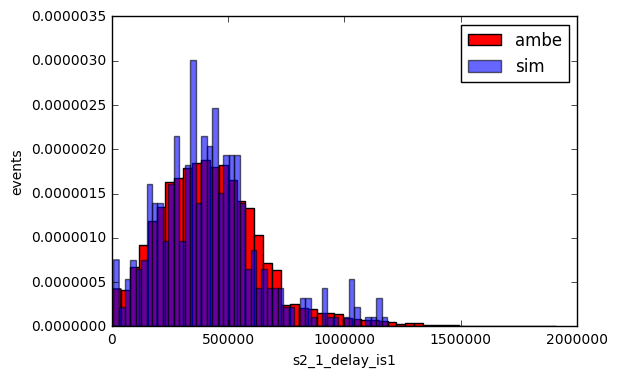

In [30]:
plt.hist(ambe.s2_1_delay_is1.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.s2_1_delay_is1.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('s2_1_delay_is1')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

In [31]:
df1 = ambe.s2_1_delay_is1
df2 = sim.s2_1_delay_is1
print('ambe \n')
describe_dist(df1)
print('\n sim')
describe_dist(df2)

ambe 

         Q1        Q3      mean    median       std
0 2.671e+05 5.504e+05 4.262e+05 4.071e+05 2.265e+05

 sim
         Q1        Q3      mean    median       std
0 2.672e+05 5.248e+05 4.172e+05 3.926e+05 2.238e+05


# S2 - Largest other S2

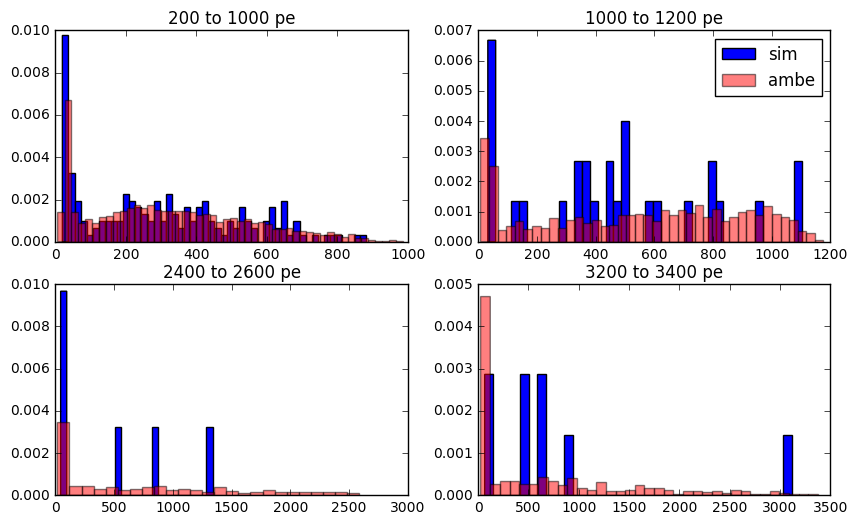

In [32]:
fig = plt.figure(figsize=(10,6))

plot_ranges = [[200,1000],[1000,1200],[2400,2600],[3200,3400]]


df_1 = sim
df_2 = ambe

# ----------------------------------------
ax = fig.add_subplot(221)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[0][0]) & (df_1.s2 < plot_ranges[0][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[0][0]) & (df_2.s2 < plot_ranges[0][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=50, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=50, color='r', alpha=0.5, label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[0][0], plot_ranges[0][1]))

# ----------------------------------------
ax = fig.add_subplot(222)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[1][0]) & (df_1.s2 < plot_ranges[1][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[1][0]) & (df_2.s2 < plot_ranges[1][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=40, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=40, color='r', alpha=0.5,  label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[1][0], plot_ranges[1][1]))

ax.legend(loc = 'upper right')

# ----------------------------------------
ax = fig.add_subplot(223)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[2][0]) & (df_1.s2 < plot_ranges[2][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[2][0]) & (df_2.s2 < plot_ranges[2][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=25, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=25, color='r', alpha=0.5,  label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[2][0], plot_ranges[2][1]))

# ----------------------------------------
ax = fig.add_subplot(224)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[3][0]) & (df_1.s2 < plot_ranges[3][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[3][0]) & (df_2.s2 < plot_ranges[3][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=35, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=35, color='r', alpha=0.5, label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[3][0], plot_ranges[3][1]))
    
plt.show()

In [33]:
bins = np.linspace(200,5000,20)
ambe_s2_and_other = slicing(ambe, 's2', 's2_1_area', bins)
sim_s2_and_other = slicing(sim, 's2', 's2_1_area', bins)

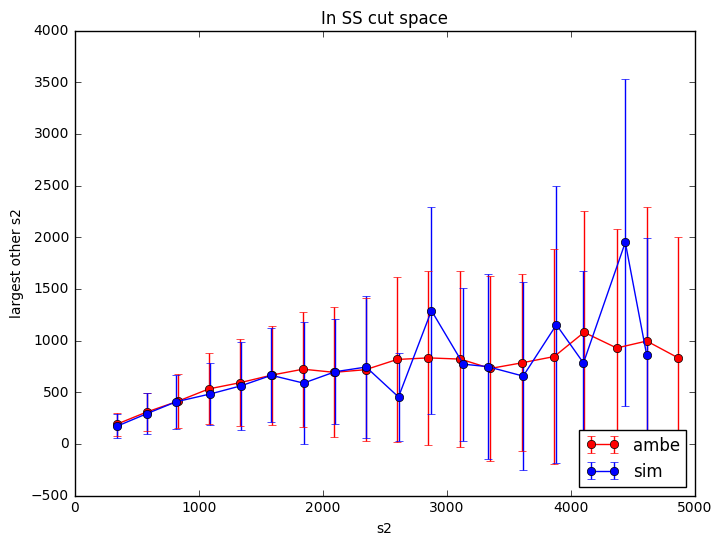

In [34]:
plt.figure(figsize=(8,6))
plt.errorbar(ambe_s2_and_other.s2, ambe_s2_and_other.s2_1_area, ambe_s2_and_other.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(sim_s2_and_other.s2, sim_s2_and_other.s2_1_area, sim_s2_and_other.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('s2')
plt.ylabel('largest other s2')

plt.title('In SS cut space')

plt.legend(loc='lower right')
plt.show()

# Diffusion

Why is simulation displaced down in the detector? z is determined via the drift time and electron lifetime. is it offset?

# Electron Lifetime

lifetime (us):567.9313628814399
+/-0.00038550300988011109


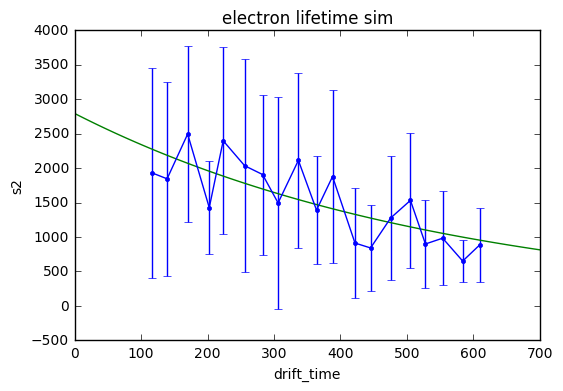

In [35]:
from scipy.optimize import curve_fit

def exp_func(x,a,b):
	return a*np.exp(-b*x)

sim['drift_time'] = sim['z'] / (1.335 * 0.1)
ambe['drift_time'] = ambe['z'] / (1.335 * 0.1)

##############################################
d1 = sim
d1.drift_time = abs(d1.drift_time)
minz = min(d1.drift_time)
maxz = max(d1.drift_time)

bins = np.linspace(minz, maxz, 20)

ds = slicing(d1, 'drift_time', 's2', bins)

popt, pcov = curve_fit(exp_func, ds.drift_time, ds.s2, p0 = (5000,1e-5))

xx = np.linspace(0,700,100)
yy = exp_func(xx, *popt)

plt.plot(ds.drift_time, ds.s2,'.',xx,yy,'-')

plt.errorbar(ds.drift_time, ds.s2, yerr = ds.sigma,color='b')

plt.title('electron lifetime sim')
plt.xlabel('drift_time')
plt.ylabel('s2')

print('lifetime (us):' + repr( 1/popt[1]))
print('+/-' + repr(np.sqrt(pcov[1,1])))

plt.show()

lifetime (us):721.89422469660838
+/-6.1285101246458042e-05


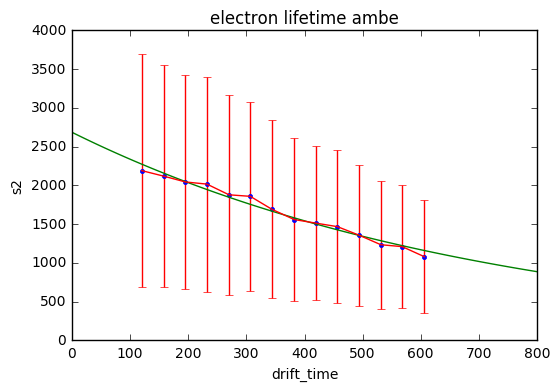

In [36]:
##############################################
d1 = ambe
d1.drift_time = abs(d1.drift_time)
minz = min(d1.drift_time)
maxz = max(d1.drift_time)

bins = np.linspace(minz, maxz, 15)

ds = slicing(d1, 'drift_time', 's2', bins)

popt, pcov = curve_fit(exp_func, ds.drift_time, ds.s2, p0 = (5000,1e-5))

xx = np.linspace(0,800,100)
yy = exp_func(xx, *popt)

plt.plot(ds.drift_time,ds.s2,'.',xx,yy,'-')

plt.errorbar(ds.drift_time, ds.s2, yerr = ds.sigma,color='r')

plt.title('electron lifetime ambe')
plt.xlabel('drift_time')
plt.ylabel('s2')

print('lifetime (us):' + repr( 1/popt[1]))
print('+/-' + repr(np.sqrt(pcov[1,1])))

plt.show()

# Area, goodness of fit

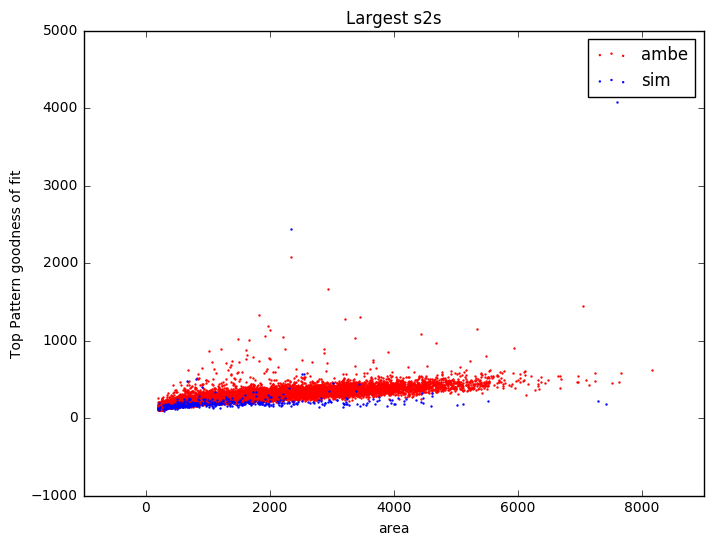

In [37]:
plt.figure(figsize = (8,6))

plt.scatter(ambe.s2, ambe.s2_pattern_fit,label='ambe',color = 'r',s = 0.5)

plt.scatter(sim.s2, sim.goodness_of_fit,label='sim',color = 'b',s = 0.5)
def area_cut(area):
    return 15*(area - 10)**.45

x = np.linspace(0,300,100)

plt.title('Largest s2s')
plt.xlabel('area')
plt.ylabel('Top Pattern goodness of fit')

# plt.plot(x, area_cut(x),color = 'g')

plt.legend(loc = 'upper right')
plt.show()

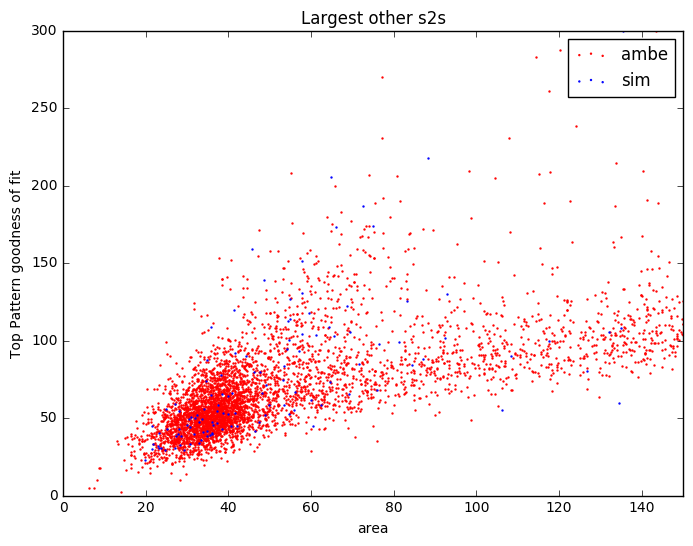

In [38]:
plt.figure(figsize = (8,6))

plt.scatter(ambe.s2_1_area, ambe.s2_1_goodness_of_fit,label='ambe',color = 'r',s = 0.5)

plt.scatter(sim.s2_1_area, sim.s2_1_goodness_of_fit,label='sim',color = 'b',s = 0.5)
def area_cut(area):
    return 15*(area - 10)**.45

x = np.linspace(0,300,100)

plt.xlim(0,150)
plt.ylim(0,300)
plt.title('Largest other s2s')
plt.xlabel('area')
plt.ylabel('Top Pattern goodness of fit')

# plt.plot(x, area_cut(x),color = 'g')

plt.legend(loc = 'upper right')
plt.show()

### GoF comparisons

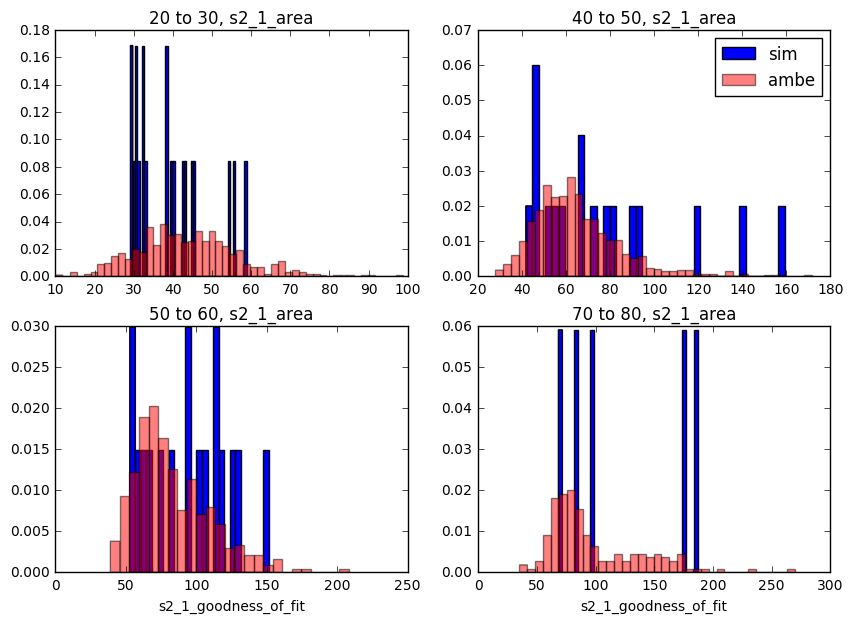

In [39]:
fig = plt.figure(figsize=(10,6))

plot_ranges = [[20,30],[40,50],[50,60],[70,80]]

four_hist_compare(sim, ambe, 's2_1_area', 's2_1_goodness_of_fit', plot_ranges)

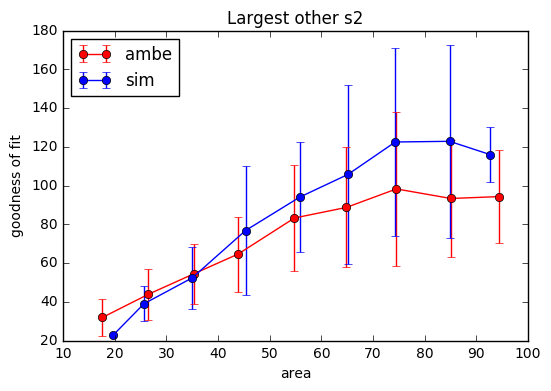

In [40]:
gof_bins = np.linspace(10,100,10)

gof_ambe = slicing(ambe, 's2_1_area', 's2_1_goodness_of_fit', gof_bins)
gof_sim = slicing(sim, 's2_1_area', 's2_1_goodness_of_fit', gof_bins)

plt.errorbar(gof_ambe.s2_1_area, gof_ambe.s2_1_goodness_of_fit, gof_ambe.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(gof_sim.s2_1_area, gof_sim.s2_1_goodness_of_fit, gof_sim.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('area')
plt.ylabel('goodness of fit')

plt.title('Largest other s2')

plt.legend(loc='upper left')
plt.show()